Make images of the backgrounds made via spline interpolation of 128x128 regions

In [71]:
import lsst.daf.persistence as dafPersist
import lsst.geom as geom
import lsst.afw.image as afwImage
import lsst.pipe.base as pipeBase

In [72]:
import os
import glob
import numpy as np
import pandas as pd
import random
from scipy import mgrid
from skimage.filters import gaussian

# img_scale is local:
import img_scale

from astropy.visualization import (MinMaxInterval, AsinhStretch, ZScaleInterval, LogStretch, LinearStretch,
                                   ImageNormalize)

In [73]:
# Set some plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
zscale = ZScaleInterval()

plt.rcParams.update({'figure.figsize' : (12, 8)})
plt.rcParams.update({'font.size' : 12})
plt.rcParams.update({'axes.linewidth' : 3})
plt.rcParams.update({'axes.labelweight' : 3})
plt.rcParams.update({'axes.titleweight' : 3})
plt.rcParams.update({'ytick.major.width' : 3})
plt.rcParams.update({'ytick.minor.width' : 2})
plt.rcParams.update({'ytick.major.size' : 8})
plt.rcParams.update({'ytick.minor.size' : 5})
plt.rcParams.update({'xtick.major.size' : 8})
plt.rcParams.update({'xtick.minor.size' : 5})
plt.rcParams.update({'xtick.major.width' : 3})
plt.rcParams.update({'xtick.minor.width' : 2})
plt.rcParams.update({'xtick.direction' : 'in'})
plt.rcParams.update({'ytick.direction' : 'in'})

In [74]:
# The output repo is tagged with the Jira ticket number "DM-22223":
rc2_repo = '/datasets/hsc/repo/rerun/RC/w_2020_03/DM-23121'

In [75]:
# Initialize the butler repo:
butler = dafPersist.Butler(rc2_repo)

# Make a glob of the files in the repo, so we can parse this to get tract/patch IDs:
#infiles = glob.glob(rc2_repo+'/deepCoadd/HSC-*/*/*/warp-*.fits') # for tract/patch/visit
infiles = glob.glob(rc2_repo+'/deepCoadd-results/HSC-*/9813/*/calexp-*.fits') # for tract/patch/filter
print(len(infiles))

388


#### Make arrays of the tract, patch numbers by parsing the filenames

In [76]:
tract_array = []
patch_array = []
#visit_array = []
filter_array = []
ra_array = []
dec_array = []

# Each line of "infiles" looks like this (infile[0]):
##### '/datasets/hsc/repo/rerun/RC/w_2019_46/DM-22223/deepCoadd/HSC-R/9615/8,8/warp-HSC-R-9615-8,8-23902.fits'
# '/datasets/hsc/repo/rerun/RC/w_2020_03/DM-23121/deepCoadd-results/HSC-G/9697/3,2/calexp-HSC-G-9697-3,2.fits'

# Split on the '/', then parse the resulting array. Here's the result of infiles[0].split('/'):

#['',
# 'datasets',
# 'hsc',
# 'repo',
# 'rerun',
# 'RC',
# 'w_2019_46',
# 'DM-22223',
# 'deepCoadd',
# 'HSC-R',
# '9615',
# '8,8',
# 'warp-HSC-R-9615-8,8-23902.fits']

# So the tract number is third from the end, and patch is second from the end.

for ii in range(0, len(infiles)):
    parts = infiles[ii].split('/')
    tract_array.append(int(parts[-3]))
    patch_array.append(parts[-2])
    filter_array.append(parts[-4])
#    # Split the file name to extract the visit number:
#    file_str = parts[-1]
#    file_str2 = file_str.split('.fits')
#    file_str3 = file_str2[0].split('-')
#    visit_array.append(file_str3[-1])

#    dataref = {'tract':int(parts[-3]), 'patch':parts[-2], 'filter':parts[-4]}
#    calexp = butler.get('deepCoadd_calexp', dataId=dataref)
#    wcs = calexp.getWcs()
#    ra_array.append(wcs.getSkyOrigin()[0].asDegrees())
#    dec_array.append(wcs.getSkyOrigin()[1].asDegrees())

print('Found %i patches'%(len(patch_array)))
        
# Assemble in pandas data frame    
data = {'tract': tract_array,
        'patch': patch_array,
#        'visit': visit_array,
        'filt': filter_array}#,
#        'ra_origin': ra_array,
#        'dec_origin': dec_array}
df_tract_patch_visit = pd.DataFrame(data=data)

Found 388 patches


In [114]:
uniqpatch = set(df_tract_patch_visit.patch)

patch_array = []
ra_array = []
dec_array = []

for patch in uniqpatch:
    dataref = {'tract':9813, 'patch':patch, 'filter':'HSC-I'}
    calexp = butler.get('deepCoadd_calexp', dataId=dataref)
    bbox = calexp.getBBox()
    wcs = calexp.getWcs()
    cen = wcs.pixelToSky(geom.Point2D(bbox.getCenterX(), bbox.getCenterY()))
    patch_array.append(patch)
    ra_array.append(cen[0].asDegrees())
    dec_array.append(cen[1].asDegrees())

# Assemble in pandas data frame    
data = {'patch': patch_array,
        'ra_cen': ra_array,
        'dec_cen': dec_array}
df_radec = pd.DataFrame(data=data)


In [115]:
df_radec

patch      ra_cen   dec_cen
0    8,0  149.503431  1.487011
1    4,5  150.247911  2.418094
2    2,1  150.621380  1.671411
3    8,6  149.502865  2.604536
4    3,7  150.434789  2.791396
5    5,4  150.061103  2.231416
6    1,1  150.808104  1.671366
7    0,1  150.992483  1.671305
8    1,2  150.808175  1.858011
9    5,6  150.061055  2.604743
10   3,1  150.434647  1.671437
11   1,0  150.808034  1.487066
12   6,7  149.874157  2.791351
13   2,3  150.621474  2.044719
14   3,0  150.434624  1.487129
15   6,0  149.874488  1.487105
16   4,0  150.247911  1.487137
17   7,2  149.687646  1.858011
18   3,3  150.434694  2.044751
19   4,6  150.247911  2.604756
20   8,4  149.503054  2.231240
21   6,2  149.874394  1.858061
22   2,7  150.621664  2.791351
23   2,4  150.621522  2.231381
24   7,3  149.687575  2.044665
25   4,4  150.247911  2.231428
26   2,5  150.621569  2.418043
27   8,1  149.503338  1.671305
28   6,8  149.874110  2.975657
29   3,2  150.434671  1.858090
..   ...         ...       ...
49   8,8  149.502677  2.975468
50   7,6  149.687361  2.604632
51   8,3  149.503149  2.044590
52   7,4  149.687503  2.231322
53   3,4  150.434718  2.231416
54   5,2  150.061150  1.858090
55   0,7  150.993050  2.791175
56   0,6  150.992956  2.604536
57   2,8  150.621711  2.975657
58   1,6  150.808460  2.604632
59   0,2  150.992578  1.857943
60   4,8  150.247911  2.975720
61   5,0  150.061197  1.487129
62   1,8  150.808601  2.975578
63   1,7  150.808531  2.791277
64   0,3  150.992672  2.044590
65   4,3  150.247911  2.044762
66   6,3  149.874347  2.044719
67   4,7  150.247911  2.791410
68   6,1  149.874441  1.671411
69   8,5  149.502960  2.417890
70   2,0  150.621333  1.487105
71   5,3  150.061127  2.044751
72   7,7  149.687290  2.791277
73   5,1  150.061174  1.671437
74   1,3  150.808247  2.044665
75   7,5  149.687432  2.417979
76   6,6  149.874204  2.604701
77   3,5  150.434742  2.418081
78   0,4  150.992767  2.231240

[79 rows x 3 columns]

Work with tract 9813, which is the COSMOS field.

In [80]:
df_tract9813 = df_tract_patch_visit.loc[df_tract_patch_visit['tract'] == 9813]

# Patch 2,3 has lots of cirrus:
#df_tract9813 = df_tract_patch_visit.loc[(df_tract_patch_visit['tract'] == 9813) & (df_tract_patch_visit['patch'] == '2,3')]

In [81]:
df_tract9813

tract patch   filt
0     9813   8,8  HSC-Y
1     9813   3,0  HSC-Y
2     9813   0,4  HSC-Y
3     9813   4,1  HSC-Y
4     9813   1,5  HSC-Y
5     9813   5,6  HSC-Y
6     9813   5,2  HSC-Y
7     9813   2,6  HSC-Y
8     9813   6,7  HSC-Y
9     9813   6,3  HSC-Y
10    9813   7,8  HSC-Y
11    9813   2,0  HSC-Y
12    9813   3,1  HSC-Y
13    9813   0,5  HSC-Y
14    9813   4,6  HSC-Y
15    9813   4,2  HSC-Y
16    9813   1,6  HSC-Y
17    9813   5,7  HSC-Y
18    9813   5,3  HSC-Y
19    9813   6,8  HSC-Y
20    9813   6,4  HSC-Y
21    9813   1,0  HSC-Y
22    9813   2,1  HSC-Y
23    9813   3,6  HSC-Y
24    9813   3,2  HSC-Y
25    9813   0,6  HSC-Y
26    9813   4,7  HSC-Y
27    9813   4,3  HSC-Y
28    9813   8,4  HSC-Y
29    9813   5,8  HSC-Y
..     ...   ...    ...
358   9813   3,4  HSC-G
359   9813   7,5  HSC-G
360   9813   7,1  HSC-G
361   9813   4,5  HSC-G
362   9813   8,6  HSC-G
363   9813   8,2  HSC-G
364   9813   0,2  HSC-G
365   9813   1,7  HSC-G
366   9813   1,3  HSC-G
367   9813   2,8  HSC-G
368   9813   5,0  HSC-G
369   9813   2,4  HSC-G
370   9813   6,5  HSC-G
371   9813   6,1  HSC-G
372   9813   3,5  HSC-G
373   9813   7,6  HSC-G
374   9813   7,2  HSC-G
375   9813   8,7  HSC-G
376   9813   8,3  HSC-G
377   9813   0,3  HSC-G
378   9813   1,8  HSC-G
379   9813   4,0  HSC-G
380   9813   1,4  HSC-G
381   9813   5,5  HSC-G
382   9813   5,1  HSC-G
383   9813   2,5  HSC-G
384   9813   6,6  HSC-G
385   9813   6,2  HSC-G
386   9813   7,7  HSC-G
387   9813   7,3  HSC-G

[388 rows x 3 columns]

In [82]:
dataref = {'tract':int(df_tract9813.tract[359]), 'patch':df_tract9813.patch[359], 'filter':df_tract9813.filt[359]}
calexp = butler.get('deepCoadd_calexp', dataId=dataref)
#dataref = {'tract':int(df_tract9697.tract[393]), 'patch':df_tract9697.patch[393], 'filter':df_tract9697.filt[393]}
#calexp_bg = butler.get('deepCoadd_calexp_background', dataId = dataref)

In [83]:
dataref_g = {'tract':9813, 'patch':'5,6', 'filter':'HSC-G'}
bg_img_g = butler.get('deepCoadd_calexp_background', dataId = dataref_g).getImage().array
#img_g = butler.get('deepCoadd_calexp', dataId = dataref_g).getImage().array
img_g = butler.get('deepCoadd', dataId = dataref_g).getImage().array
dataref_r = {'tract':9813, 'patch':'5,6', 'filter':'HSC-R'}
bg_img_r = butler.get('deepCoadd_calexp_background', dataId = dataref_r).getImage().array
img_r = butler.get('deepCoadd', dataId = dataref_r).getImage().array
#img_r = butler.get('deepCoadd_calexp', dataId = dataref_r).getImage().array
dataref_i = {'tract':9813, 'patch':'5,6', 'filter':'HSC-I'}
bg_img_i = butler.get('deepCoadd_calexp_background', dataId = dataref_i).getImage().array
img_i = butler.get('deepCoadd', dataId = dataref_i).getImage().array
calexp_i = butler.get('deepCoadd', dataId = dataref_i)
#img_i = butler.get('deepCoadd_calexp', dataId = dataref_i).getImage().array
#img_g=calexp_g.getImage().array
#img_r=calexp_r.getImage().array
#img_i=calexp_i.getImage().array
#bg_img_g=calexp_bg_g.getImage().array
#bg_img_r=calexp_bg_r.getImage().array
#bg_img_i=calexp_bg_i.getImage().array

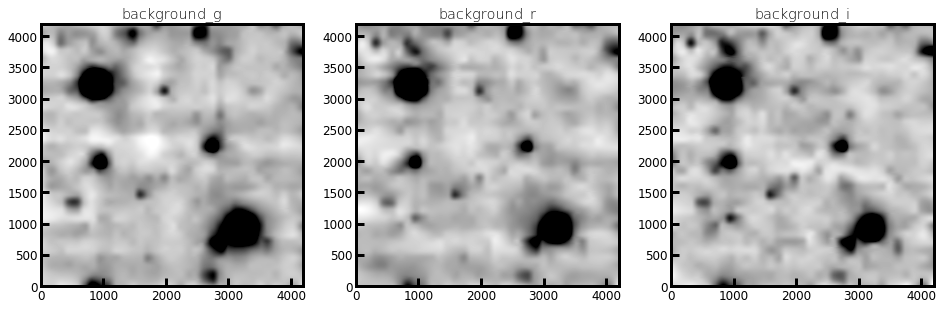

In [84]:
# Set up some plotting defaults:
plt.rcParams.update({'figure.figsize' : (16, 12)})
plt.rcParams.update({'font.size' : 12})

#ncols = 3
f, ax = plt.subplots(1, 3)
#axnum = 0
axs = ax.flatten()

# Create an ImageNormalize object
norm_g = ImageNormalize(bg_img_g, interval=ZScaleInterval(),
                        stretch=LinearStretch())
norm_r = ImageNormalize(bg_img_r, interval=ZScaleInterval(),
                        stretch=LinearStretch())
norm_i = ImageNormalize(bg_img_i, interval=ZScaleInterval(),
                        stretch=LinearStretch())

im0 = axs[0].imshow(bg_img_g, norm=norm_g, origin='lower', cmap='binary')
axs[0].set_title('background_g')
#    plt.colorbar(im0, ax=axs[0])
#    axnum += 1
im1 = axs[1].imshow(bg_img_r, norm=norm_r, origin='lower', cmap='binary')
axs[1].set_title('background_r')
#    plt.colorbar(im1, ax=axs[1])
#    axnum += 1
im2 = axs[2].imshow(bg_img_i, norm=norm_i, origin='lower', cmap='binary')
axs[2].set_title('background_i')
#    plt.colorbar(im2, ax=axs[2])
#    axnum += 1

plt.show()

In [86]:
# RGB image of the background:
bg_img_gri = np.zeros((bg_img_i.shape[0], bg_img_i.shape[1], 3), dtype=float)
bg_iscale = img_scale.range_from_zscale(bg_img_i)
bg_gscale = img_scale.range_from_zscale(bg_img_g)
bg_rscale = img_scale.range_from_zscale(bg_img_r)

In [87]:
#img[:,:,0] = img_scale.linear(i, scale_min=-0.01, scale_max=3.0*iscale[1])
#img[:,:,1] = img_scale.linear(r, scale_min=-0.01, scale_max=3.0*rscale[1])
#img[:,:,2] = img_scale.linear(g, scale_min=-0.01, scale_max=3.0*gscale[1])
bg_img_gri[:,:,0] = img_scale.linear(bg_img_i, scale_min=bg_iscale[0], scale_max=3.0*bg_iscale[1])
bg_img_gri[:,:,1] = img_scale.linear(bg_img_r, scale_min=bg_rscale[0], scale_max=3.0*bg_rscale[1])
bg_img_gri[:,:,2] = img_scale.linear(bg_img_g, scale_min=bg_gscale[0], scale_max=3.0*bg_gscale[1])

In [88]:
# RGB image of the deepCoadd calexp:
img_gri = np.zeros((img_i.shape[0], img_i.shape[1], 3), dtype=float)
iscale = img_scale.range_from_zscale(img_i)
gscale = img_scale.range_from_zscale(img_g)
rscale = img_scale.range_from_zscale(img_r)

In [89]:
#img_gri[:,:,0] = img_scale.linear(img_i, scale_min=-0.01, scale_max=3.0*iscale[1])
#img_gri[:,:,1] = img_scale.linear(img_r, scale_min=-0.01, scale_max=3.0*rscale[1])
#img_gri[:,:,2] = img_scale.linear(img_g, scale_min=-0.01, scale_max=3.0*gscale[1])
img_gri[:,:,0] = img_scale.linear(img_i, scale_min=iscale[0], scale_max=3.0*iscale[1])
img_gri[:,:,1] = img_scale.linear(img_r, scale_min=rscale[0], scale_max=3.0*rscale[1])
img_gri[:,:,2] = img_scale.linear(img_g, scale_min=gscale[0], scale_max=3.0*gscale[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


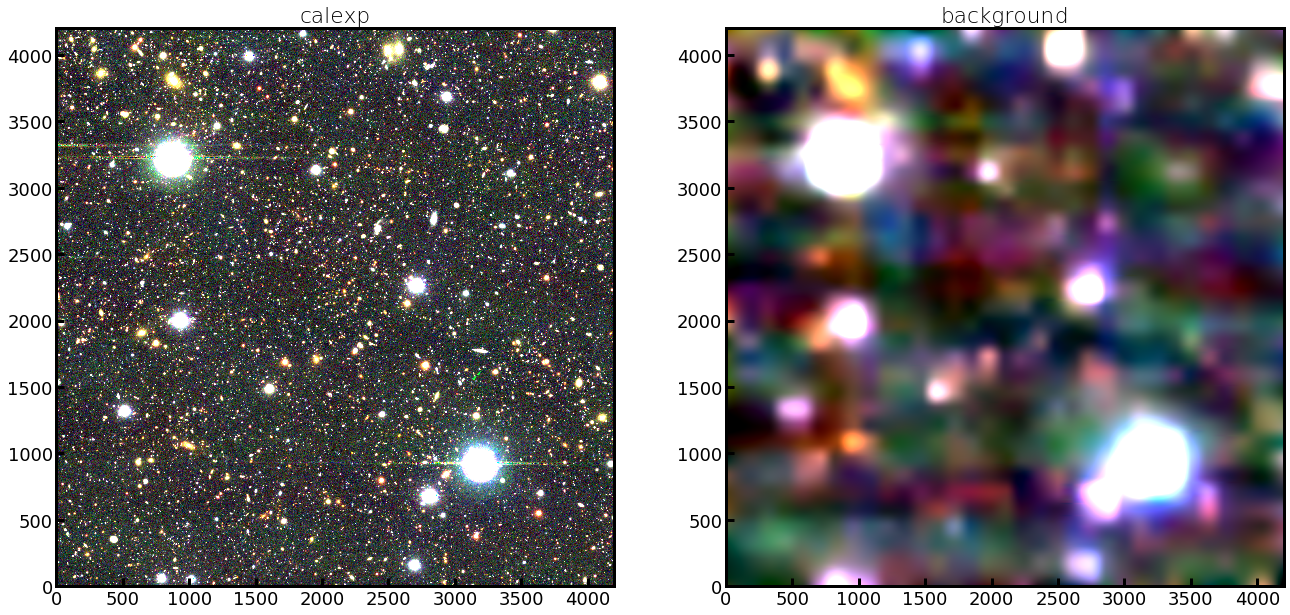

In [90]:
norm_gri = ImageNormalize(img_gri, interval=ZScaleInterval(),
                          stretch=LinearStretch())
norm_bg_gri = ImageNormalize(bg_img_gri, interval=ZScaleInterval(),
                             stretch=LinearStretch())

plt.rcParams.update({'figure.figsize' : (22, 12)})
plt.rcParams.update({'font.size' : 18})

f, ax = plt.subplots(1, 2)
axs = ax.flatten()

im0 = axs[0].imshow(img_gri, norm=norm_gri, origin='lower')
axs[0].set_title('calexp')
im1 = axs[1].imshow(bg_img_gri, norm=norm_bg_gri, origin='lower')
axs[1].set_title('background')
plt.show()

### Now try mosaicking multiple patches together
Remember to cut off the 100-pixel overlaps!

In [91]:
# Start near patch 2,3, which has lots of cirrus:
df_tract9813_patch46 = df_tract_patch_visit.loc[(df_tract_patch_visit['tract'] == 9813) & (df_tract_patch_visit['patch'] == '4,6')]
df_tract9813_patch56 = df_tract_patch_visit.loc[(df_tract_patch_visit['tract'] == 9813) & (df_tract_patch_visit['patch'] == '5,6')]
df_tract9813_patch45 = df_tract_patch_visit.loc[(df_tract_patch_visit['tract'] == 9813) & (df_tract_patch_visit['patch'] == '4,5')]
df_tract9813_patch55 = df_tract_patch_visit.loc[(df_tract_patch_visit['tract'] == 9813) & (df_tract_patch_visit['patch'] == '5,5')]


In [92]:
df_tract9813_patch46

tract patch   filt
14    9813   4,6  HSC-Y
92    9813   4,6  HSC-R
167   9813   4,6  HSC-Z
245   9813   4,6  HSC-I
324   9813   4,6  HSC-G

In [93]:
### Select the tract/patch in g-band filter, then the same tract/patch in R, I:
df_g46 = df_tract9813_patch46[(df_tract9813_patch46['filt'] == 'HSC-G')]
df_r46 = df_tract9813_patch46[(df_tract9813_patch46['filt'] == 'HSC-R') & (df_tract9813_patch46['tract'] == int(df_g46.tract.values[0])) & (df_tract9813_patch46['patch'] == str(df_g46.patch.values[0]))]
df_i46 = df_tract9813_patch46[(df_tract9813_patch46['filt'] == 'HSC-I') & (df_tract9813_patch46['tract'] == int(df_g46.tract.values[0])) & (df_tract9813_patch46['patch'] == str(df_g46.patch.values[0]))]

df_g56 = df_tract9813_patch56[(df_tract9813_patch56['filt'] == 'HSC-G')]
df_r56 = df_tract9813_patch56[(df_tract9813_patch56['filt'] == 'HSC-R') & (df_tract9813_patch56['tract'] == int(df_g56.tract.values[0])) & (df_tract9813_patch56['patch'] == str(df_g56.patch.values[0]))]
df_i56 = df_tract9813_patch56[(df_tract9813_patch56['filt'] == 'HSC-I') & (df_tract9813_patch56['tract'] == int(df_g56.tract.values[0])) & (df_tract9813_patch56['patch'] == str(df_g56.patch.values[0]))]

df_g45 = df_tract9813_patch45[(df_tract9813_patch45['filt'] == 'HSC-G')]
df_r45 = df_tract9813_patch45[(df_tract9813_patch45['filt'] == 'HSC-R') & (df_tract9813_patch45['tract'] == int(df_g45.tract.values[0])) & (df_tract9813_patch45['patch'] == str(df_g45.patch.values[0]))]
df_i45 = df_tract9813_patch45[(df_tract9813_patch45['filt'] == 'HSC-I') & (df_tract9813_patch45['tract'] == int(df_g45.tract.values[0])) & (df_tract9813_patch45['patch'] == str(df_g45.patch.values[0]))]

df_g55 = df_tract9813_patch55[(df_tract9813_patch55['filt'] == 'HSC-G')]
df_r55 = df_tract9813_patch55[(df_tract9813_patch55['filt'] == 'HSC-R') & (df_tract9813_patch55['tract'] == int(df_g55.tract.values[0])) & (df_tract9813_patch55['patch'] == str(df_g55.patch.values[0]))]
df_i55 = df_tract9813_patch55[(df_tract9813_patch55['filt'] == 'HSC-I') & (df_tract9813_patch55['tract'] == int(df_g55.tract.values[0])) & (df_tract9813_patch55['patch'] == str(df_g55.patch.values[0]))]


In [94]:
dataref_g46 = {'tract':int(df_g46.tract.values[0]), 'patch':df_g46.patch.values[0], 'filter':df_g46.filt.values[0]}
dataref_r46 = {'tract':int(df_r46.tract.values[0]), 'patch':df_r46.patch.values[0], 'filter':df_r46.filt.values[0]}
dataref_i46 = {'tract':int(df_i46.tract.values[0]), 'patch':df_i46.patch.values[0], 'filter':df_i46.filt.values[0]}
dataref_g56 = {'tract':int(df_g56.tract.values[0]), 'patch':df_g56.patch.values[0], 'filter':df_g56.filt.values[0]}
dataref_r56 = {'tract':int(df_r56.tract.values[0]), 'patch':df_r56.patch.values[0], 'filter':df_r56.filt.values[0]}
dataref_i56 = {'tract':int(df_i56.tract.values[0]), 'patch':df_i56.patch.values[0], 'filter':df_i56.filt.values[0]}
dataref_g45 = {'tract':int(df_g45.tract.values[0]), 'patch':df_g45.patch.values[0], 'filter':df_g45.filt.values[0]}
dataref_r45 = {'tract':int(df_r45.tract.values[0]), 'patch':df_r45.patch.values[0], 'filter':df_r45.filt.values[0]}
dataref_i45 = {'tract':int(df_i45.tract.values[0]), 'patch':df_i45.patch.values[0], 'filter':df_i45.filt.values[0]}
dataref_g55 = {'tract':int(df_g55.tract.values[0]), 'patch':df_g55.patch.values[0], 'filter':df_g55.filt.values[0]}
dataref_r55 = {'tract':int(df_r55.tract.values[0]), 'patch':df_r55.patch.values[0], 'filter':df_r55.filt.values[0]}
dataref_i55 = {'tract':int(df_i55.tract.values[0]), 'patch':df_i55.patch.values[0], 'filter':df_i55.filt.values[0]}


In [95]:
img_g46 = butler.get('deepCoadd', dataId = dataref_g46).getImage().array
img_g56 = butler.get('deepCoadd', dataId = dataref_g56).getImage().array
img_g45 = butler.get('deepCoadd', dataId = dataref_g45).getImage().array
img_g55 = butler.get('deepCoadd', dataId = dataref_g55).getImage().array
bg_img_g46 = butler.get('deepCoadd_calexp_background', dataId = dataref_g46).getImage().array
bg_img_g56 = butler.get('deepCoadd_calexp_background', dataId = dataref_g56).getImage().array
bg_img_g45 = butler.get('deepCoadd_calexp_background', dataId = dataref_g45).getImage().array
bg_img_g55 = butler.get('deepCoadd_calexp_background', dataId = dataref_g55).getImage().array
img_r46 = butler.get('deepCoadd', dataId = dataref_r46).getImage().array
img_r56 = butler.get('deepCoadd', dataId = dataref_r56).getImage().array
img_r45 = butler.get('deepCoadd', dataId = dataref_r45).getImage().array
img_r55 = butler.get('deepCoadd', dataId = dataref_r55).getImage().array
bg_img_r46 = butler.get('deepCoadd_calexp_background', dataId = dataref_r46).getImage().array
bg_img_r56 = butler.get('deepCoadd_calexp_background', dataId = dataref_r56).getImage().array
bg_img_r45 = butler.get('deepCoadd_calexp_background', dataId = dataref_r45).getImage().array
bg_img_r55 = butler.get('deepCoadd_calexp_background', dataId = dataref_r55).getImage().array
img_i46 = butler.get('deepCoadd', dataId = dataref_i46).getImage().array
img_i56 = butler.get('deepCoadd', dataId = dataref_i56).getImage().array
img_i45 = butler.get('deepCoadd', dataId = dataref_i45).getImage().array
img_i55 = butler.get('deepCoadd', dataId = dataref_i55).getImage().array
bg_img_i46 = butler.get('deepCoadd_calexp_background', dataId = dataref_i46).getImage().array
bg_img_i56 = butler.get('deepCoadd_calexp_background', dataId = dataref_i56).getImage().array
bg_img_i45 = butler.get('deepCoadd_calexp_background', dataId = dataref_i45).getImage().array
bg_img_i55 = butler.get('deepCoadd_calexp_background', dataId = dataref_i55).getImage().array


In [96]:
def rebin( a, newshape ):
        '''Rebin an array to a new shape.
        '''
        assert len(a.shape) == len(newshape)

        slices = [ slice(0,old, float(old)/new) for old,new in zip(a.shape,newshape) ]
        coordinates = mgrid[slices]
        indices = coordinates.astype('i')   #choose the biggest smaller integer index
        return a[tuple(indices)]

In [104]:
smth_scale = 5

# g-band
bg_img_g45_trim = bg_img_g45[:-100,:-100]
bg_img_g46_trim = bg_img_g46[100:,:-100]
bg_img_g55_trim = bg_img_g55[:-100,100:]
bg_img_g56_trim = bg_img_g56[100:,100:]
#bg_img_g55_trim = bg_img_g55[:-100,100:]
bg_img_g45_trim_rebin = rebin(bg_img_g45_trim, (np.shape(bg_img_g45_trim)[0]/2,np.shape(bg_img_g45_trim)[1]/2)) # Cut down by half
bg_img_g46_trim_rebin = rebin(bg_img_g46_trim, (np.shape(bg_img_g46_trim)[0]/2,np.shape(bg_img_g46_trim)[1]/2)) # Cut down by half
bg_img_g55_trim_rebin = rebin(bg_img_g55_trim, (np.shape(bg_img_g55_trim)[0]/2,np.shape(bg_img_g55_trim)[1]/2)) # Cut down by half
bg_img_g56_trim_rebin = rebin(bg_img_g56_trim, (np.shape(bg_img_g56_trim)[0]/2,np.shape(bg_img_g56_trim)[1]/2)) # Cut down by half
img_g45_trim = img_g45[:-100,:-100]
img_g46_trim = img_g46[100:,:-100]
img_g55_trim = img_g55[:-100,100:]
img_g56_trim = img_g56[100:,100:]
#img_g55_trim = img_g55[:-100,100:]
img_g45_trim_rebin = rebin(gaussian(img_g45_trim, sigma=smth_scale), (np.shape(img_g45_trim)[0]/2,np.shape(img_g45_trim)[1]/2)) # Cut down by half
img_g46_trim_rebin = rebin(gaussian(img_g46_trim, sigma=smth_scale), (np.shape(img_g46_trim)[0]/2,np.shape(img_g46_trim)[1]/2)) # Cut down by half
img_g55_trim_rebin = rebin(gaussian(img_g55_trim, sigma=smth_scale), (np.shape(img_g55_trim)[0]/2,np.shape(img_g55_trim)[1]/2)) # Cut down by half
img_g56_trim_rebin = rebin(gaussian(img_g56_trim, sigma=smth_scale), (np.shape(img_g56_trim)[0]/2,np.shape(img_g56_trim)[1]/2)) # Cut down by half
#img_g46_trim_rebin = rebin(img_g46_trim, (np.shape(img_g46_trim)[0]/2,np.shape(img_g46_trim)[1]/2)) # Cut down by half
#img_g56_trim_rebin = rebin(img_g56_trim, (np.shape(img_g56_trim)[0]/2,np.shape(img_g56_trim)[1]/2)) # Cut down by half
#img_g45_trim_rebin = rebin(img_g45_trim, (np.shape(img_g45_trim)[0]/2,np.shape(img_g45_trim)[1]/2)) # Cut down by half
#img_g55_trim_rebin = rebin(img_g55_trim, (np.shape(img_g55_trim)[0]/2,np.shape(img_g55_trim)[1]/2)) # Cut down by half
# r-band
bg_img_r45_trim = bg_img_r45[:-100,:-100]
bg_img_r46_trim = bg_img_r46[100:,:-100]
bg_img_r55_trim = bg_img_r55[:-100,100:]
bg_img_r56_trim = bg_img_r56[100:,100:]
#bg_img_r55_trim = bg_img_r55[:-100,100:]
bg_img_r45_trim_rebin = rebin(bg_img_r45_trim, (np.shape(bg_img_r45_trim)[0]/2,np.shape(bg_img_r45_trim)[1]/2)) # Cut down by half
bg_img_r46_trim_rebin = rebin(bg_img_r46_trim, (np.shape(bg_img_r46_trim)[0]/2,np.shape(bg_img_r46_trim)[1]/2)) # Cut down by half
bg_img_r55_trim_rebin = rebin(bg_img_r55_trim, (np.shape(bg_img_r55_trim)[0]/2,np.shape(bg_img_r55_trim)[1]/2)) # Cut down by half
bg_img_r56_trim_rebin = rebin(bg_img_r56_trim, (np.shape(bg_img_r56_trim)[0]/2,np.shape(bg_img_r56_trim)[1]/2)) # Cut down by half
img_r45_trim = img_r45[:-100,:-100]
img_r46_trim = img_r46[100:,:-100]
img_r55_trim = img_r55[:-100,100:]
img_r56_trim = img_r56[100:,100:]
#img_r55_trim = img_r55[:-100,100:]
img_r45_trim_rebin = rebin(gaussian(img_r45_trim, sigma=smth_scale), (np.shape(img_r45_trim)[0]/2,np.shape(img_r45_trim)[1]/2)) # Cut down by half
img_r46_trim_rebin = rebin(gaussian(img_r46_trim, sigma=smth_scale), (np.shape(img_r46_trim)[0]/2,np.shape(img_r46_trim)[1]/2)) # Cut down by half
img_r55_trim_rebin = rebin(gaussian(img_r55_trim, sigma=smth_scale), (np.shape(img_r55_trim)[0]/2,np.shape(img_r55_trim)[1]/2)) # Cut down by half
img_r56_trim_rebin = rebin(gaussian(img_r56_trim, sigma=smth_scale), (np.shape(img_r56_trim)[0]/2,np.shape(img_r56_trim)[1]/2)) # Cut down by half
#img_r46_trim_rebin = rebin(img_r46_trim, (np.shape(img_r46_trim)[0]/2,np.shape(img_r46_trim)[1]/2)) # Cut down by half
#img_r56_trim_rebin = rebin(img_r56_trim, (np.shape(img_r56_trim)[0]/2,np.shape(img_r56_trim)[1]/2)) # Cut down by half
#img_r45_trim_rebin = rebin(img_r45_trim, (np.shape(img_r45_trim)[0]/2,np.shape(img_r45_trim)[1]/2)) # Cut down by half
#img_r55_trim_rebin = rebin(img_r55_trim, (np.shape(img_r55_trim)[0]/2,np.shape(img_r55_trim)[1]/2)) # Cut down by half
# i-band
bg_img_i45_trim = bg_img_i45[:-100,:-100]
bg_img_i46_trim = bg_img_i46[100:,:-100]
bg_img_i55_trim = bg_img_i55[:-100,100:]
bg_img_i56_trim = bg_img_i56[100:,100:]
#bg_img_i55_trim = bg_img_i55[:-100,100:]
bg_img_i45_trim_rebin = rebin(bg_img_i45_trim, (np.shape(bg_img_i45_trim)[0]/2,np.shape(bg_img_i45_trim)[1]/2)) # Cut down by half
bg_img_i46_trim_rebin = rebin(bg_img_i46_trim, (np.shape(bg_img_i46_trim)[0]/2,np.shape(bg_img_i46_trim)[1]/2)) # Cut down by half
bg_img_i55_trim_rebin = rebin(bg_img_i55_trim, (np.shape(bg_img_i55_trim)[0]/2,np.shape(bg_img_i55_trim)[1]/2)) # Cut down by half
bg_img_i56_trim_rebin = rebin(bg_img_i56_trim, (np.shape(bg_img_i56_trim)[0]/2,np.shape(bg_img_i56_trim)[1]/2)) # Cut down by half
img_i45_trim = img_i45[:-100,:-100]
img_i46_trim = img_i46[100:,:-100]
img_i55_trim = img_i55[:-100,100:]
img_i56_trim = img_i56[100:,100:]
#img_i55_trim = img_i55[:-100,100:]
img_i45_trim_rebin = rebin(gaussian(img_i45_trim, sigma=smth_scale), (np.shape(img_i45_trim)[0]/2,np.shape(img_i45_trim)[1]/2)) # Cut down by half
img_i46_trim_rebin = rebin(gaussian(img_i46_trim, sigma=smth_scale), (np.shape(img_i46_trim)[0]/2,np.shape(img_i46_trim)[1]/2)) # Cut down by half
img_i55_trim_rebin = rebin(gaussian(img_i55_trim, sigma=smth_scale), (np.shape(img_i55_trim)[0]/2,np.shape(img_i55_trim)[1]/2)) # Cut down by half
img_i56_trim_rebin = rebin(gaussian(img_i56_trim, sigma=smth_scale), (np.shape(img_i56_trim)[0]/2,np.shape(img_i56_trim)[1]/2)) # Cut down by half


/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10
/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in log10
/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in log10
/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in log10


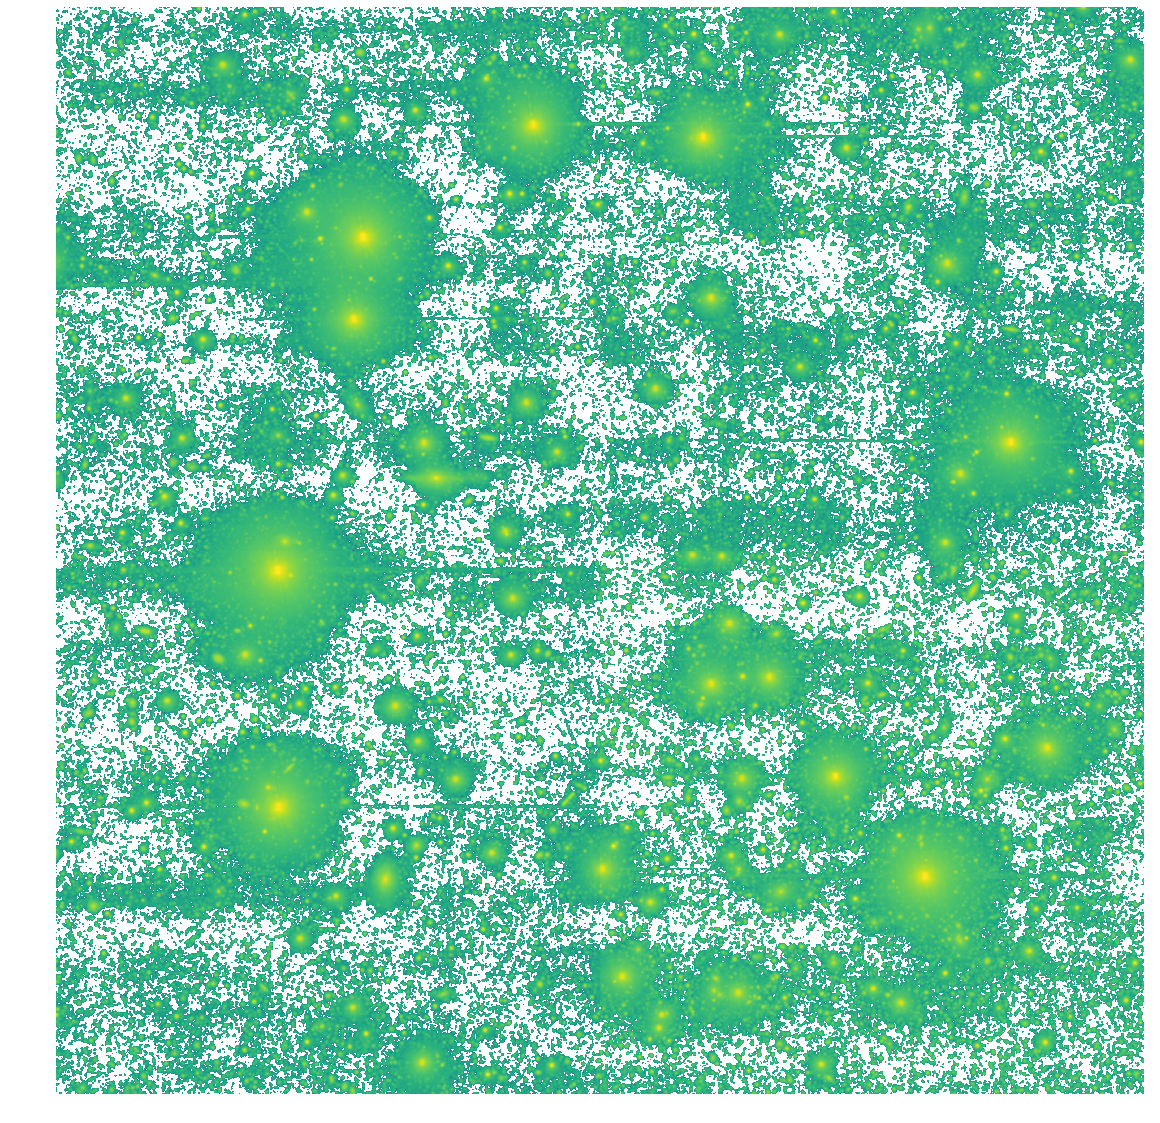

In [105]:
plt.rcParams.update({'figure.figsize' : (19.5, 20)})
fig=plt.figure()
fig.subplots_adjust(wspace=0, hspace=0)

ax1 = plt.subplot(221)
ax1.axis('off')
im1 = ax1.imshow(np.log10(img_g46_trim_rebin), origin='lower')
ax2 = plt.subplot(222, sharey=ax1)
ax2.axis('off')
im2 = ax2.imshow(np.log10(img_g56_trim_rebin), origin='lower')
ax3 = plt.subplot(223, sharex=ax1)
ax3.axis('off')
im3 = ax3.imshow(np.log10(img_g45_trim_rebin), origin='lower')
ax4 = plt.subplot(224, sharex=ax2, sharey=ax3)
ax4.axis('off')
im4 = ax4.imshow(np.log10(img_g55_trim_rebin), origin='lower')

plt.show()

In [106]:
# RGB image of the background:
bg_img_gri46 = np.zeros((bg_img_i46_trim_rebin.shape[0], bg_img_i46_trim_rebin.shape[1], 3), dtype=float)
bg_iscale = img_scale.range_from_zscale(bg_img_i46_trim_rebin)
bg_gscale = img_scale.range_from_zscale(bg_img_g46_trim_rebin)
bg_rscale = img_scale.range_from_zscale(bg_img_r46_trim_rebin)

bg_img_gri46[:,:,0] = img_scale.linear(bg_img_i46_trim_rebin, scale_min=bg_iscale[0], scale_max=3.0*bg_iscale[1])
bg_img_gri46[:,:,1] = img_scale.linear(bg_img_r46_trim_rebin, scale_min=bg_rscale[0], scale_max=3.0*bg_rscale[1])
bg_img_gri46[:,:,2] = img_scale.linear(bg_img_g46_trim_rebin, scale_min=bg_gscale[0], scale_max=3.0*bg_gscale[1])

# RGB image of the coaddd:
img_gri46 = np.zeros((img_i46_trim_rebin.shape[0], img_i46_trim_rebin.shape[1], 3), dtype=float)
iscale = img_scale.range_from_zscale(img_i46_trim_rebin)
gscale = img_scale.range_from_zscale(img_g46_trim_rebin)
rscale = img_scale.range_from_zscale(img_r46_trim_rebin)

img_gri46[:,:,0] = img_scale.linear(img_i46_trim_rebin, scale_min=iscale[0], scale_max=3.0*iscale[1])
img_gri46[:,:,1] = img_scale.linear(img_r46_trim_rebin, scale_min=rscale[0], scale_max=3.0*rscale[1])
img_gri46[:,:,2] = img_scale.linear(img_g46_trim_rebin, scale_min=gscale[0], scale_max=3.0*gscale[1])

In [107]:
# RGB image of the background:
bg_img_gri56 = np.zeros((bg_img_i56_trim_rebin.shape[0], bg_img_i56_trim_rebin.shape[1], 3), dtype=float)
bg_iscale = img_scale.range_from_zscale(bg_img_i56_trim_rebin)
bg_gscale = img_scale.range_from_zscale(bg_img_g56_trim_rebin)
bg_rscale = img_scale.range_from_zscale(bg_img_r56_trim_rebin)

bg_img_gri56[:,:,0] = img_scale.linear(bg_img_i56_trim_rebin, scale_min=bg_iscale[0], scale_max=3.0*bg_iscale[1])
bg_img_gri56[:,:,1] = img_scale.linear(bg_img_r56_trim_rebin, scale_min=bg_rscale[0], scale_max=3.0*bg_rscale[1])
bg_img_gri56[:,:,2] = img_scale.linear(bg_img_g56_trim_rebin, scale_min=bg_gscale[0], scale_max=3.0*bg_gscale[1])

# RGB image of the coaddd:
img_gri56 = np.zeros((img_i56_trim_rebin.shape[0], img_i56_trim_rebin.shape[1], 3), dtype=float)
iscale = img_scale.range_from_zscale(img_i56_trim_rebin)
gscale = img_scale.range_from_zscale(img_g56_trim_rebin)
rscale = img_scale.range_from_zscale(img_r56_trim_rebin)

img_gri56[:,:,0] = img_scale.linear(img_i56_trim_rebin, scale_min=iscale[0], scale_max=3.0*iscale[1])
img_gri56[:,:,1] = img_scale.linear(img_r56_trim_rebin, scale_min=rscale[0], scale_max=3.0*rscale[1])
img_gri56[:,:,2] = img_scale.linear(img_g56_trim_rebin, scale_min=gscale[0], scale_max=3.0*gscale[1])

In [108]:
# RGB image of the background:
bg_img_gri45 = np.zeros((bg_img_i45_trim_rebin.shape[0], bg_img_i45_trim_rebin.shape[1], 3), dtype=float)
bg_iscale = img_scale.range_from_zscale(bg_img_i45_trim_rebin)
bg_gscale = img_scale.range_from_zscale(bg_img_g45_trim_rebin)
bg_rscale = img_scale.range_from_zscale(bg_img_r45_trim_rebin)

bg_img_gri45[:,:,0] = img_scale.linear(bg_img_i45_trim_rebin, scale_min=bg_iscale[0], scale_max=3.0*bg_iscale[1])
bg_img_gri45[:,:,1] = img_scale.linear(bg_img_r45_trim_rebin, scale_min=bg_rscale[0], scale_max=3.0*bg_rscale[1])
bg_img_gri45[:,:,2] = img_scale.linear(bg_img_g45_trim_rebin, scale_min=bg_gscale[0], scale_max=3.0*bg_gscale[1])

# RGB image of the coaddd:
img_gri45 = np.zeros((img_i45_trim_rebin.shape[0], img_i45_trim_rebin.shape[1], 3), dtype=float)
iscale = img_scale.range_from_zscale(img_i45_trim_rebin)
gscale = img_scale.range_from_zscale(img_g45_trim_rebin)
rscale = img_scale.range_from_zscale(img_r45_trim_rebin)

img_gri45[:,:,0] = img_scale.linear(img_i45_trim_rebin, scale_min=iscale[0], scale_max=3.0*iscale[1])
img_gri45[:,:,1] = img_scale.linear(img_r45_trim_rebin, scale_min=rscale[0], scale_max=3.0*rscale[1])
img_gri45[:,:,2] = img_scale.linear(img_g45_trim_rebin, scale_min=gscale[0], scale_max=3.0*gscale[1])

In [109]:
# RGB image of the background:
bg_img_gri55 = np.zeros((bg_img_i55_trim_rebin.shape[0], bg_img_i55_trim_rebin.shape[1], 3), dtype=float)
bg_iscale = img_scale.range_from_zscale(bg_img_i55_trim_rebin)
bg_gscale = img_scale.range_from_zscale(bg_img_g55_trim_rebin)
bg_rscale = img_scale.range_from_zscale(bg_img_r55_trim_rebin)

bg_img_gri55[:,:,0] = img_scale.linear(bg_img_i55_trim_rebin, scale_min=bg_iscale[0], scale_max=3.0*bg_iscale[1])
bg_img_gri55[:,:,1] = img_scale.linear(bg_img_r55_trim_rebin, scale_min=bg_rscale[0], scale_max=3.0*bg_rscale[1])
bg_img_gri55[:,:,2] = img_scale.linear(bg_img_g55_trim_rebin, scale_min=bg_gscale[0], scale_max=3.0*bg_gscale[1])

# RGB image of the coaddd:
img_gri55 = np.zeros((img_i55_trim_rebin.shape[0], img_i55_trim_rebin.shape[1], 3), dtype=float)
iscale = img_scale.range_from_zscale(img_i55_trim_rebin)
gscale = img_scale.range_from_zscale(img_g55_trim_rebin)
rscale = img_scale.range_from_zscale(img_r55_trim_rebin)

img_gri55[:,:,0] = img_scale.linear(img_i55_trim_rebin, scale_min=iscale[0], scale_max=3.0*iscale[1])
img_gri55[:,:,1] = img_scale.linear(img_r55_trim_rebin, scale_min=rscale[0], scale_max=3.0*rscale[1])
img_gri55[:,:,2] = img_scale.linear(img_g55_trim_rebin, scale_min=gscale[0], scale_max=3.0*gscale[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


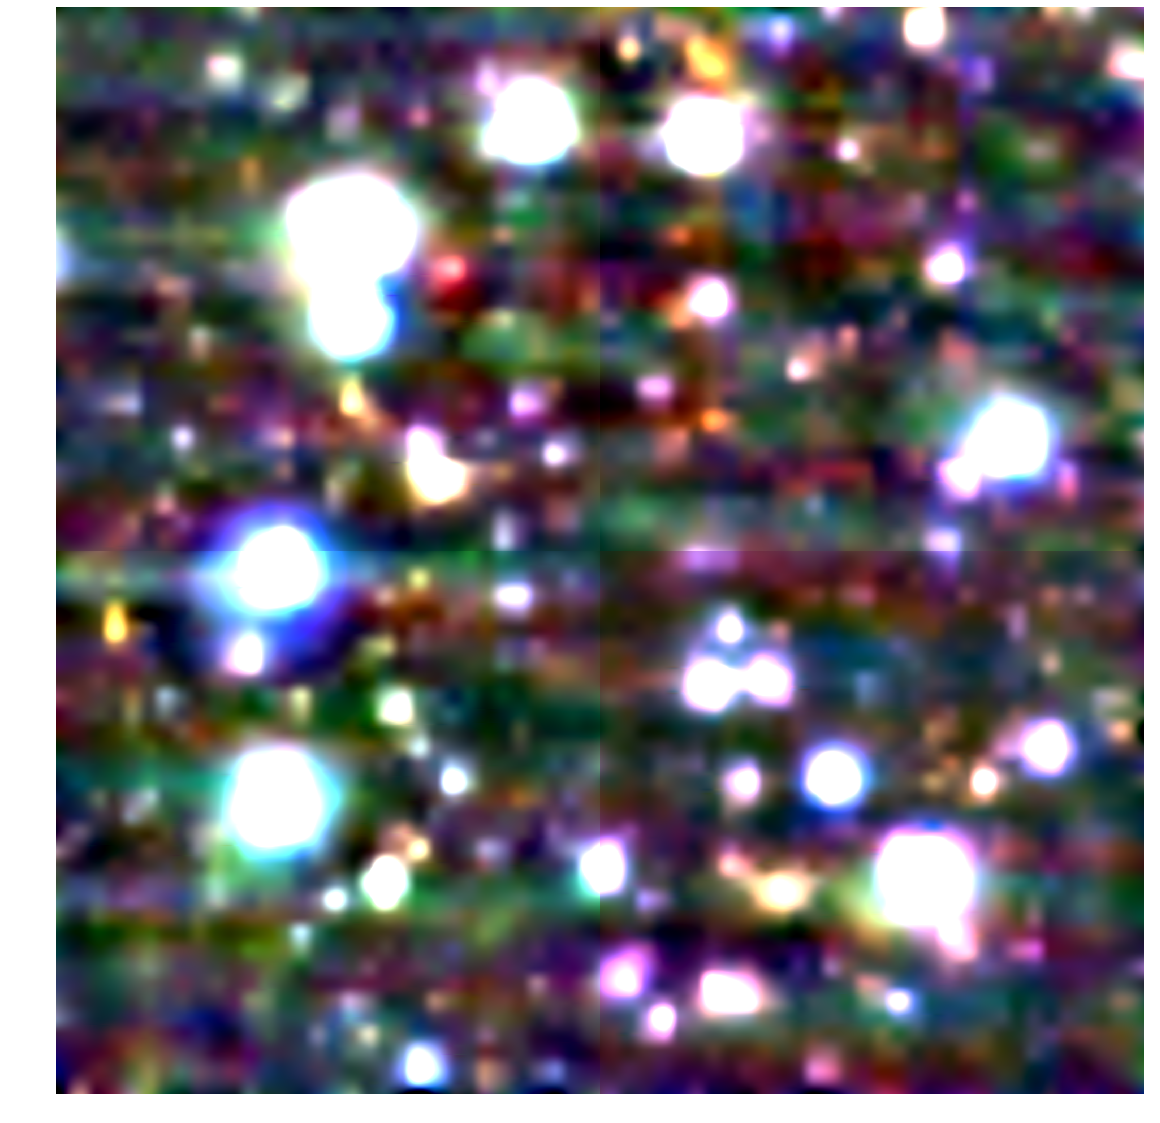

In [119]:
plt.rcParams.update({'figure.figsize' : (19.5, 20)})
fig=plt.figure()
fig.subplots_adjust(wspace=0, hspace=0)

ax1 = plt.subplot(221)
ax1.axis('off')
im1 = ax1.imshow(bg_img_gri46, origin='lower')
ax2 = plt.subplot(222, sharey=ax1)
ax2.axis('off')
im2 = ax2.imshow(bg_img_gri56, origin='lower')
ax3 = plt.subplot(223, sharex=ax1)
ax3.axis('off')
im3 = ax3.imshow(bg_img_gri45, origin='lower')
ax4 = plt.subplot(224, sharex=ax2, sharey=ax3)
ax4.axis('off')
im4 = ax4.imshow(bg_img_gri55, origin='lower')

#plt.savefig('coadd_patches23_24_33_34.png')
plt.show()